In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch

from sklearn.cluster import KMeans

In [2]:
#trop_dbh = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'
wytham_ss_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ss_dbh.csv'
wytham_ms_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ms_dbh.csv'
trop_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'

wytham_qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"
trop_qsm_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/MLA01_man.csv'


In [ ]:
trop_dbh

In [33]:
# make wytham qsm dataset
wytham_qsm = pd.read_csv(wytham_qsm_path)


wytham_qsm = wytham_qsm[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


wytham_qsm['TLS_ID'] = wytham_qsm['TLS_ID'].astype(str)



# make wytham dbh dataset
wytham_ss_dbh = pd.read_csv(wytham_ss_dbh_path, index_col = [0])
wytham_ss_dbh['TLS_ID'] = wytham_ss_dbh['TLS_ID'].astype(str)

wytham_ms_dbh = pd.read_csv(wytham_ms_dbh_path, index_col = [0])
wytham_ms_dbh['TLS_ID'] = wytham_ms_dbh['TLS_ID'].astype(str)

# multi-stems have to be at least 10cm diameter
wytham_ms_dbh = wytham_ms_dbh[wytham_ms_dbh['dbhadj'] > 0.1]

# concatenate to get full wytham dataset
wytham_dbh = pd.concat([wytham_ss_dbh, wytham_ms_dbh])

# merge dbh and qsm datasets
wytham = wytham_dbh.merge(wytham_qsm, on ='TLS_ID').dropna(axis=0)

# make tropical qsm dataset
trop_qsm = pd.read_csv(trop_qsm_path)
trop_qsm['TLS_ID'] = trop_qsm['tree'].str[11:]
trop_qsm = trop_qsm.drop(['tree', 'x_m', 'y_m'], axis='columns')

# make tropical dbh dataset
trop_dbh = pd.read_csv(trop_dbh_path, index_col = [0])
trop_dbh['TLS_ID'] = trop_dbh['TLS_ID'].astype(str)

tropical = trop_dbh.merge(trop_qsm, on ='TLS_ID').dropna(axis=0)



In [24]:
tropical

,TLS_ID,dbh_hgt,dbh13,dbhadj,stems,maxdist13,maxdistadj,avgresid,dbhcirc,Flagged,...,TotalArea,DBHqsm,DBHcyl,VolumeCylDiam,LengthCylDiam,VolumeBranchOrder,LengthBranchOrder,NumberBranchOrder,TotalVolume_T,BranchLength_T
0,T38,1.3,0.169398,0.169398,1,0.113272,0.113272,0.000043,0.153172,0,...,103.897911,0.150406,0.153630,2.608255,95.428375,113.037018,0.547678,27.0,0.511232,112.138435
1,T39,1.6,0.618474,0.614378,1,0.487661,0.463900,0.001130,0.575220,0,...,79.768562,0.584898,0.584898,0.793138,25.034153,323.390228,0.613538,22.0,4.891671,132.894501
2,T187,1.3,0.186533,0.186533,1,0.027790,0.027790,0.000057,0.159470,0,...,27.285250,0.131781,0.145083,0.599663,17.588295,86.829964,0.308532,17.0,0.246036,41.255219
3,T115,1.3,0.128498,0.128498,1,0.029471,0.029471,0.000065,0.107136,0,...,11.037519,0.104561,0.106924,0.664305,28.211014,13.397456,0.214685,13.0,0.094990,14.843892
4,T94,1.3,0.168175,0.168175,1,0.172850,0.172850,0.000060,0.149141,0,...,62.484737,0.143904,0.150098,1.817901,74.254700,157.625381,0.872357,39.0,0.423498,115.060547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,T220,1.3,0.141124,0.141124,1,0.113442,0.113442,0.000083,0.109994,0,...,15.572714,0.106292,0.109752,1.534170,49.063271,30.452681,0.266157,21.0,0.080643,17.194490
171,T489,3.1,0.133212,0.136092,1,0.100048,0.034360,0.000051,0.109991,0,...,26.533419,0.117475,0.117699,2.448270,85.630363,24.080524,0.247979,20.0,0.088543,14.734681
172,T256,1.9,0.290366,0.267343,1,0.236297,0.099656,0.000098,0.237662,0,...,162.076645,0.251787,0.254648,3.409710,145.973694,423.334320,1.069906,43.0,2.139094,378.515381
173,T139,1.3,0.170605,0.170605,1,0.095944,0.095944,0.000087,0.151822,0,...,71.729874,0.150747,0.152838,1.714010,59.636490,113.488289,0.649006,31.0,0.405902,105.027908


In [34]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=False)

Text(0, 0.5, 'DBH from TLS')

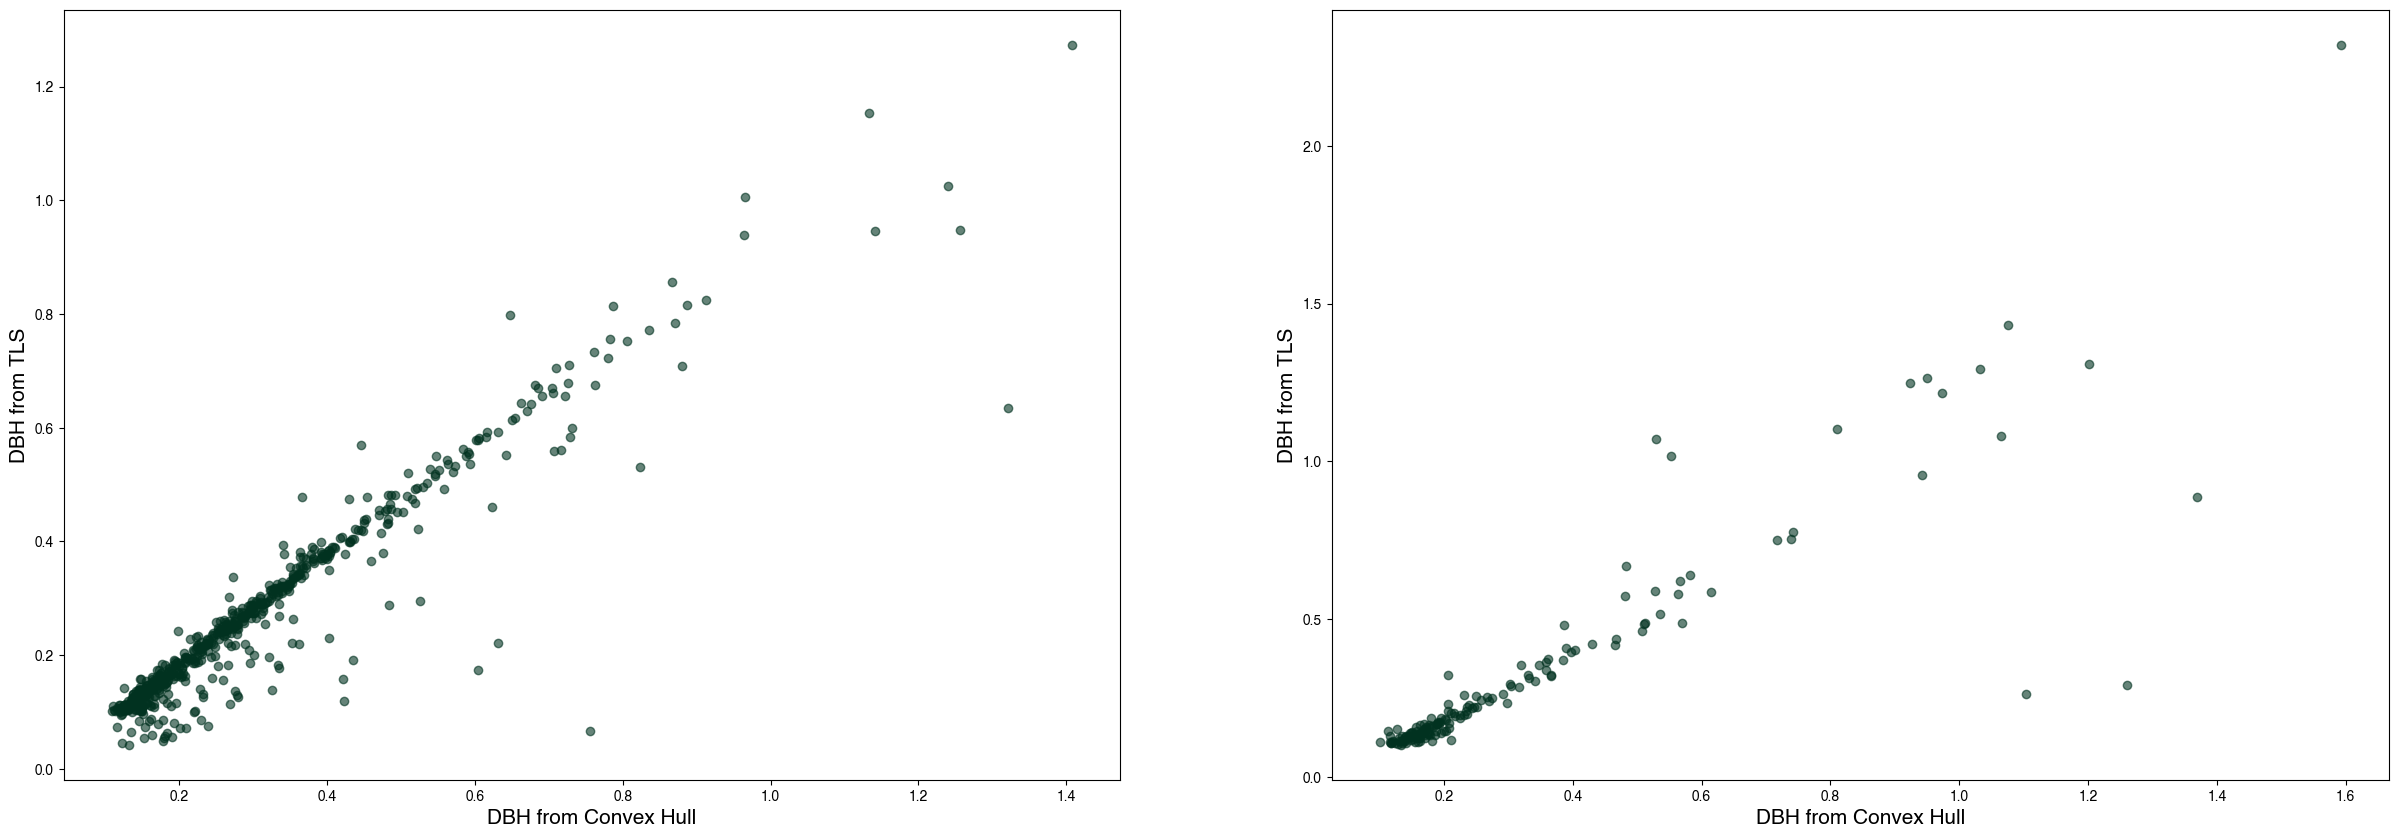

In [35]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

#smalltrees = treedata[treedata['DBH_CV']<4]

fig, axs = plt.subplots(1, 2, figsize=(30,10))


axs[0].scatter(wytham['dbhadj'], wytham['DBH_TLS_[m]'], color='#013220', alpha=0.6)
axs[0].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[0].set_ylabel('DBH from TLS', fontsize=15)

axs[1].scatter(tropical['dbhadj'], tropical['DBHqsm'], color='#013220', alpha=0.6)
axs[1].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[1].set_ylabel('DBH from TLS', fontsize=15)



In [72]:
# drop flagged trees 
print(f'length of wytham before {len(wytham)}')
wytham  = wytham[wytham['Flagged']==0]
print(f'length of wytham after {len(wytham)}')

print(f'length of tropical before {len(tropical)}')
tropical  = tropical[tropical['Flagged']==0]
print(f'length of tropical after {len(tropical)}')

length of wytham before 588
length of wytham after 588
length of tropical before 163
length of tropical after 158


In [81]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(wytham['dbhadj'])

# Remove the labels from the features (axis 1 refers to the columns)
features = wytham.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
#features = tropical.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [82]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [83]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (441, 20)
Training Labels Shape: (441,)
Testing Features Shape: (147, 20)
Testing Labels Shape: (147,)


In [84]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [85]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 0.02
Accuracy: 94.34 %.


In [86]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Vol_QSM_avg_[m3]     Importance: 0.51
Variable: Vol_QSM_D500_1000mm_avg_[m3] Importance: 0.3
Variable: Vol_QSM_D200_500mm_avg_[m3] Importance: 0.11
Variable: avgresid             Importance: 0.02
Variable: maxdistadj           Importance: 0.01
Variable: resid_norm           Importance: 0.01
Variable: Vol_QSM_D100_200mm_avg_[m3] Importance: 0.01
Variable: Vol_QSM_D1000mm_avg_[m3] Importance: 0.01
Variable: dbh_hgt              Importance: 0.0
Variable: stems                Importance: 0.0
Variable: maxdist13            Importance: 0.0
Variable: Flagged              Importance: 0.0
Variable: stemlocx_[m]         Importance: 0.0
Variable: stemlocy_[m]         Importance: 0.0
Variable: Hgt_pts_[m]          Importance: 0.0
Variable: VerticalCrownProjectedArea_pts_[m2] Importance: 0.0
Variable: Vol_QSM_D0_25mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D25_50mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D50_75mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D75_100mm_avg_[m3] Importan

Text(0, 0.5, 'Measured Values (DBH)')

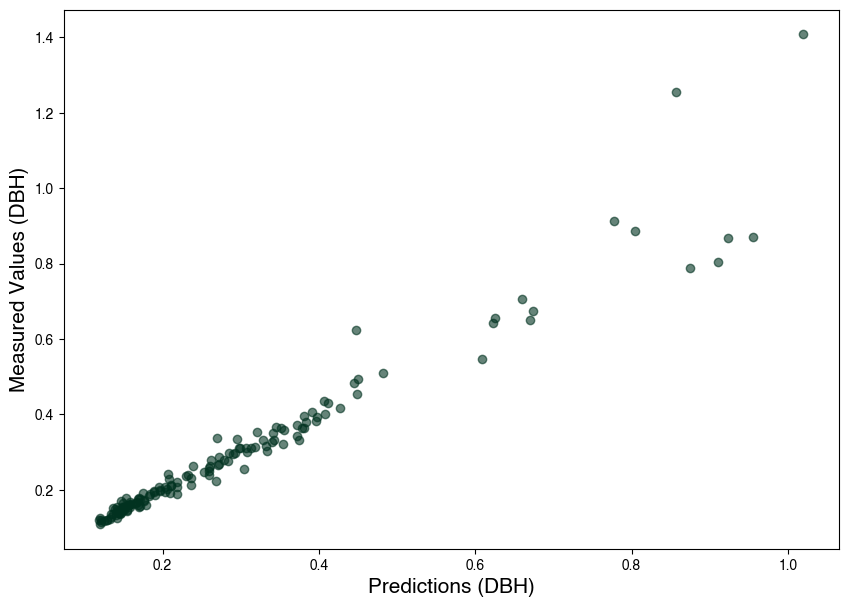

In [87]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'], color='#013220', alpha=0.6)
plt.xlabel('Predictions (DBH)', fontsize=15)
plt.ylabel('Measured Values (DBH)', fontsize=15)



Text(0, 0.5, 'Errors')

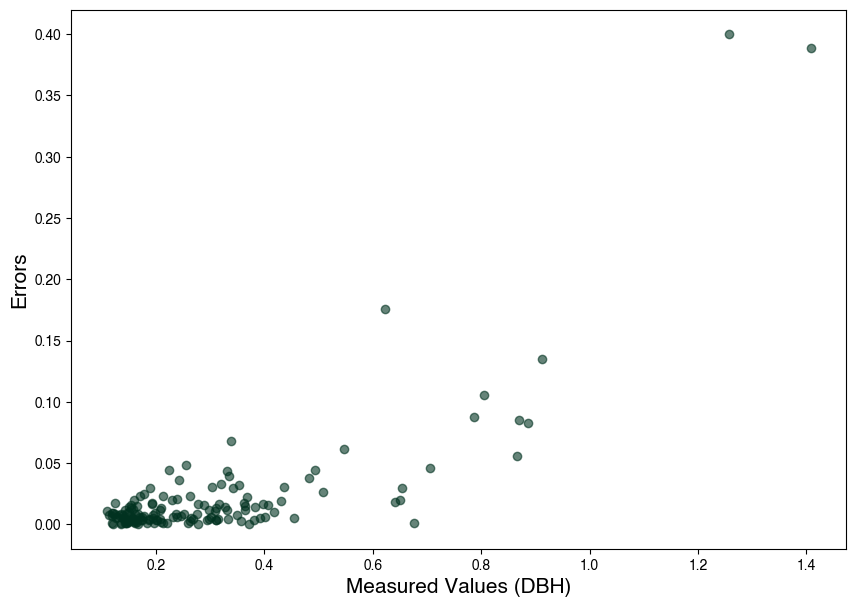

In [88]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'], color='#013220', alpha=0.6)
plt.xlabel('Measured Values (DBH)', fontsize=15)
plt.ylabel('Errors', fontsize=15)